<a href="https://colab.research.google.com/github/RaisaAnika/model-confidence_CIFAR10/blob/main/CIS545_Fall22_ModelConfidence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 Model and Some Useful Starter Code

This starter code is to help you have a CIFAR-10 model that is trained on the whole dataset. You will also find some helper functions for splitting the dataset into $n$ disjoint sets (from which you can train individual models that will serve in the ensemble).

The CIFAR10 dataset contains 60K color images in 10 classes, with 6K images in each class. The dataset is divided into 50K training images and 10K testing images. The classes are mutually exclusive and there is no overlap between them. The 10 classes are ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'].




In [34]:
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 5.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-privacy 0.8.4 requires matplotlib~=3.3.4, but you have matplotlib 3.1.3 which is incompatible.


In [35]:
import tensorflow as tf
from keras.models import Model   
from keras.layers import *
import matplotlib.pyplot as plt

In [39]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, GlobalAveragePooling2D, \
Dense, Input, Activation, MaxPool2D
from tensorflow.keras import Model

import sklearn.metrics

from numpy.random import default_rng
rng = default_rng()
AUTO = tf.data.AUTOTUNE

In [2]:
!pip install tensorflow_privacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 301 kB 5.0 MB/s 
     |████████████████████████████████| 5.7 MB 8.3 MB/s 
     |████████████████████████████████| 301 kB 34.7 MB/s 
     |████████████████████████████████| 287 kB 6.3 MB/s 
     |████████████████████████████████| 287 kB 39.8 MB/s 
     |████████████████████████████████| 126 kB 35.1 MB/s 
     |████████████████████████████████| 4.2 MB 38.2 MB/s 
     |████████████████████████████████| 60 kB 4.2 MB/s 
     |████████████████████████████████| 11.5 MB 33.1 MB/s 
     |████████████████████████████████| 9.5 MB 15.6 MB/s 
     |████████████████████████████████| 82 kB 632 kB/s 
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.3.0
    Uninstalling absl-py-1.3.0:
      Successfully uninstalled absl-py-1.3.0
  Attempting uninstall: attrs
    Found existing installation: attrs 22.1.0
    Uninstalling attrs-22.1.0:
      

In [3]:
!pip install tensorflow-privacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
###Tensorflow attack libraries

from tensorflow_privacy.privacy.membership_inference_attack import membership_inference_attack as mia
#from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack as mia 
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackType

/usr/local/lib/python3.7/dist-packages/tensorflow_privacy/privacy/membership_inference_attack/__init__.py:19: UserWarning: 
Membership inference attack sources were moved. Please replace
import tensorflow_privacy.privacy.membership_inference_attack

with
import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack
  "\nMembership inference attack sources were moved. Please replace"


In [5]:
# download CIFAR-10 dataset and split it into train and test set
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


170498071/170498071 [==============================] - 2s 0us/step


In [6]:
print(x_train.shape[0])

50000


In [7]:
print(x_test.shape[0])

10000


In [8]:
print(y_train)

[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


In [9]:
# normalze pixel values to be in the range [0,1] instead of [0, 255]
x_train, x_test= x_train/ 255.0, x_test / 255.0



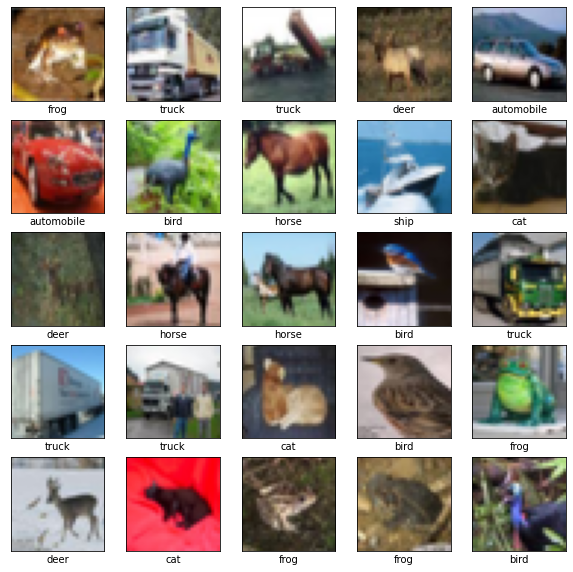

In [36]:
# let's check what individual samples in the training data look like just for verification

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(labels[y_train[i][0]])
plt.show()



In [11]:
def define_model():
  """ This model is fairly simple, feel free to play with this part in pursuit of a better accuracy architecture.
  """
  shape = (32, 32, 3)
  input = Input(shape=shape)
  x = Conv2D(32, (3, 3), activation='relu')(input)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)

  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  x = Dense(10)(x)
  model = Model(input, x)
  return model

In [12]:
# check model summary
model = define_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928 

In [13]:
# specify parameters
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# train the model
history = model.fit(x_train, y_train,
                       validation_data=(x_test, y_test),
                       batch_size=128, 
                       epochs=10)
history

Epoch 1/10
391/391 [==============================] - 77s 190ms/step - loss: 1.7087 - accuracy: 0.3758 - val_loss: 1.4564 - val_accuracy: 0.4686
Epoch 2/10
391/391 [==============================] - 70s 179ms/step - loss: 1.3671 - accuracy: 0.5087 - val_loss: 1.2631 - val_accuracy: 0.5510
Epoch 3/10
391/391 [==============================] - 71s 182ms/step - loss: 1.2116 - accuracy: 0.5661 - val_loss: 1.1705 - val_accuracy: 0.5781
Epoch 4/10
391/391 [==============================] - 68s 175ms/step - loss: 1.1216 - accuracy: 0.6033 - val_loss: 1.0880 - val_accuracy: 0.6179
Epoch 5/10
391/391 [==============================] - 71s 182ms/step - loss: 1.0321 - accuracy: 0.6383 - val_loss: 1.0402 - val_accuracy: 0.6361
Epoch 6/10
391/391 [==============================] - 69s 175ms/step - loss: 0.9792 - accuracy: 0.6576 - val_loss: 1.0544 - val_accuracy: 0.6382
Epoch 7/10
391/391 [==============================] - 71s 182ms/step - loss: 0.9311 - accuracy: 0.6733 - val_loss: 0.9725 - val_ac

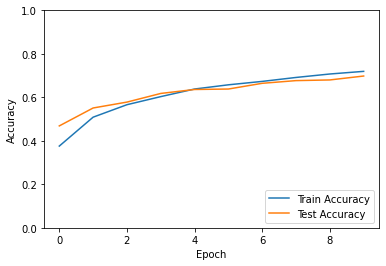

In [37]:
# evalaute model accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [15]:
# predict probabilities
import numpy as np
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(x_test)




313/313 [==============================] - 6s 19ms/step


In [16]:
print(predictions)

[[1.09748880e-03 2.07041344e-03 2.40373053e-02 ... 2.10223661e-04
  5.03679365e-02 1.06430345e-03]
 [6.79186080e-03 8.81714746e-02 5.12106044e-06 ... 1.82658670e-08
  9.04781699e-01 2.45841249e-04]
 [1.10408664e-01 2.29383320e-01 2.35251826e-03 ... 2.92050710e-04
  5.93011260e-01 5.66278659e-02]
 ...
 [7.19325681e-06 2.42713531e-06 1.18259303e-02 ... 7.92960729e-03
  1.86282341e-05 1.43220313e-05]
 [1.91447902e-02 1.48119956e-01 1.25382259e-03 ... 1.40007673e-04
  1.64888424e-05 9.59095545e-04]
 [4.27089508e-05 1.92377702e-05 2.63447780e-03 ... 9.42575395e-01
  2.92683035e-06 1.45185579e-04]]


In [17]:
index =0
for p in predictions:
  print( p, np.argmax(p),y_test[index])
  index+=1

Streaming output truncated to the last 5000 lines.
 3.7762469e-01 1.6195089e-02 3.6344811e-01 8.2927938e-05 3.4926721e-04] 5 [5]
[0.03268307 0.01600696 0.02078088 0.42848468 0.01120239 0.4309094
 0.01412682 0.00766258 0.01340231 0.02474084] 5 [0]
[0.00715909 0.00168291 0.11855942 0.2677347  0.06753142 0.13741459
 0.04624088 0.3491967  0.00266836 0.00181195] 7 [7]
[5.2071288e-02 2.3000480e-03 3.4012938e-01 8.4234685e-02 1.0664431e-01
 4.7510709e-03 2.1291731e-01 1.9556764e-01 1.0549299e-03 3.2931697e-04] 2 [7]
[2.0169497e-03 7.3215590e-05 3.7990060e-02 1.9532816e-01 1.0275315e-03
 2.6513189e-01 5.3245798e-03 2.6123038e-01 1.6321766e-04 2.3171411e-01] 5 [7]
[6.8538112e-04 3.3387825e-02 2.4639929e-04 3.2348366e-04 7.6690951e-05
 1.8305602e-04 6.7311915e-04 2.5905744e-04 1.1607386e-04 9.6404892e-01] 9 [9]
[1.6000538e-04 3.4987268e-06 5.6946494e-02 2.8823472e-03 9.2473578e-01
 2.1046596e-03 1.1942782e-02 1.2176132e-03 2.7368430e-06 4.0641330e-06] 4 [4]
[4.7196641e-05 3.1273416e-05 3.5687461

In [18]:
predictions_trained_data = probability_model.predict(x_train)

1563/1563 [==============================] - 25s 16ms/step


In [19]:
print(predictions_trained_data)

[[3.3827411e-05 1.7054532e-05 1.9784153e-02 ... 2.5778408e-03
  1.0086934e-05 1.7870209e-06]
 [7.0542219e-04 2.4471739e-03 1.1246977e-03 ... 3.3114303e-04
  1.8300489e-04 9.9516350e-01]
 [6.0710363e-02 2.0739298e-02 2.6645409e-02 ... 3.7934817e-02
  1.3158481e-02 5.8988518e-01]
 ...
 [4.2006161e-02 1.1764297e-01 2.4620369e-03 ... 2.2544374e-04
  2.6580503e-02 8.0774677e-01]
 [9.7875316e-03 9.7699857e-01 2.1160329e-05 ... 4.3520881e-06
  9.8404819e-03 3.1711876e-03]
 [2.7643180e-01 3.6469552e-01 6.4042039e-02 ... 4.1521220e-03
  1.6802557e-01 6.2621631e-02]]


In [20]:
#Attack Model Build-up

prob_train = predictions_trained_data
prob_test= predictions


In [21]:
yt=y_train[0:5000]
ys=y_test[5000:10000]

In [22]:
len(y_test)

10000

In [23]:
len(y_train)

50000

In [24]:
(unique, counts) = np.unique(ys, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[  0, 512],
       [  1, 495],
       [  2, 488],
       [  3, 503],
       [  4, 493],
       [  5, 512],
       [  6, 509],
       [  7, 505],
       [  8, 496],
       [  9, 487]])

In [25]:
# define what variables our attacker should have access to

attack_input = AttackInputData(
  logits_train = prob_train,
  logits_test = prob_test,
  #loss_train = loss_train,
  #loss_test = loss_test,
  labels_train =yt,
  labels_test =ys
)

In [26]:
len(prob_train)

50000

In [27]:
len(yt)

5000

In [28]:
attack_input

AttackInputData(logits_train=array([[3.3827411e-05, 1.7054532e-05, 1.9784153e-02, ..., 2.5778408e-03,
        1.0086934e-05, 1.7870209e-06],
       [7.0542219e-04, 2.4471739e-03, 1.1246977e-03, ..., 3.3114303e-04,
        1.8300489e-04, 9.9516350e-01],
       [6.0710363e-02, 2.0739298e-02, 2.6645409e-02, ..., 3.7934817e-02,
        1.3158481e-02, 5.8988518e-01],
       ...,
       [4.2006161e-02, 1.1764297e-01, 2.4620369e-03, ..., 2.2544374e-04,
        2.6580503e-02, 8.0774677e-01],
       [9.7875316e-03, 9.7699857e-01, 2.1160329e-05, ..., 4.3520881e-06,
        9.8404819e-03, 3.1711876e-03],
       [2.7643180e-01, 3.6469552e-01, 6.4042039e-02, ..., 4.1521220e-03,
        1.6802557e-01, 6.2621631e-02]], dtype=float32), logits_test=array([[1.09748880e-03, 2.07041344e-03, 2.40373053e-02, ...,
        2.10223661e-04, 5.03679365e-02, 1.06430345e-03],
       [6.79186080e-03, 8.81714746e-02, 5.12106044e-06, ...,
        1.82658670e-08, 9.04781699e-01, 2.45841249e-04],
       [1.10408664e-01

In [29]:
# how should the data be sliced
slicing_spec = SlicingSpec(
    entire_dataset = True,
    by_class = False,
    by_percentiles = False,
    by_classification_correctness = True)

In [30]:
# define the type of attacker model that we want to use
attack_type = [
    AttackType.MULTI_LAYERED_PERCEPTRON
]

In [40]:
len(y_train)

50000

In [42]:
### MMD+MiXUP - regularisation based defence
n = len(y_train)
val_samples = 2000
x_val, y_val = x_train[30000:40000], y_train[30000:40000] ### validation dataset defined


In [ ]:
print(x_val)

In [44]:
batch_size = 128
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)


In [45]:
len(val_ds)

79

In [46]:

for images, labels in val_ds:  # only take first element of dataset
    x_val = images.numpy()
    y_val = labels.numpy()

In [51]:
x_val

array([[[[0.78823529, 0.83529412, 0.89803922],
         [0.78823529, 0.83529412, 0.92941176],
         [0.79215686, 0.83921569, 0.9372549 ],
         ...,
         [0.43529412, 0.51372549, 0.6745098 ],
         [0.29803922, 0.38431373, 0.54901961],
         [0.25098039, 0.37254902, 0.53333333]],

        [[0.80784314, 0.85490196, 0.89803922],
         [0.78823529, 0.84705882, 0.89803922],
         [0.77254902, 0.84705882, 0.92156863],
         ...,
         [0.14901961, 0.2627451 , 0.44705882],
         [0.1254902 , 0.22745098, 0.41176471],
         [0.13333333, 0.25882353, 0.43529412]],

        [[0.76862745, 0.80784314, 0.83921569],
         [0.70588235, 0.76862745, 0.79607843],
         [0.63921569, 0.7254902 , 0.8       ],
         ...,
         [0.05490196, 0.13333333, 0.2627451 ],
         [0.04705882, 0.09803922, 0.23137255],
         [0.04705882, 0.09411765, 0.22745098]],

        ...,

        [[0.27843137, 0.26666667, 0.10588235],
         [0.33333333, 0.3254902 , 0.13333333]

In [52]:
y_val

array([[9],
       [7],
       [6],
       [1],
       [7],
       [3],
       [1],
       [2],
       [8],
       [9],
       [6],
       [0],
       [1],
       [6],
       [2],
       [8]], dtype=uint8)

In [53]:
def sample_beta_distribution(size, concentration_0=0.3, concentration_1=0.3):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

In [54]:
def mix_up(ds_one, ds_two, alpha=0.3):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return images, labels

In [55]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, batch_size=64, shuffle=True):
        super().__init__()
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.key_array = np.arange(self.images.shape[0], dtype=np.uint32)
        self.on_epoch_end()

    def __len__(self):
        return len(self.key_array)//self.batch_size

    def __getitem__(self, index):
        keys = self.key_array[index*self.batch_size:(index+1)*self.batch_size]
        x = np.asarray(self.images[keys], dtype=np.float32)
        y = np.asarray(self.labels[keys], dtype=np.float32)
        return x, y

    def on_epoch_end(self):
        if self.shuffle:
            self.key_array = np.random.permutation(self.key_array)

In [58]:
generator1 = DataGenerator(images=x_train[0:int(n/2)], labels=y_train[0:int(n/2)], batch_size=batch_size, shuffle=True)
generator2 = DataGenerator(images=x_train[int(n/2):n], labels=y_train[int(n/2):n], batch_size=batch_size, shuffle=True)
n_batches = len(generator1)

In [61]:
print(n_batches)

195


In [62]:
print(n)

50000


In [57]:
!pip install tensorflow-model-remediation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 142 kB 5.1 MB/s 


In [63]:
n_epochs= 10 #epochs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
ce_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

loss_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
acc_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
loss_val = np.zeros(shape=(n_epochs,))
acc_val = np.zeros(shape=(n_epochs,))

In [64]:
from tensorflow_model_remediation import min_diff
import tensorflow as tf
mmd_loss=min_diff.losses.MMDLoss()

In [65]:
def train_ds(new_x_train,new_y_train):
  train_ds_one = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(batch_size * 100)
    .batch(batch_size)
)
  train_ds_two = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(batch_size * 100)
    .batch(batch_size)
)
  train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))
  return train_ds

In [66]:
def numpy_img(train_ds_mu):
  for images, labels in train_ds_mu:  # only take first element of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    #l = l.numpy()
    return numpy_images,numpy_labels

In [67]:
#define the model 
model_mmd= define_model()#AlexnetModel(shape,num_class)
val_train_dif=30

In [72]:
len(generator2)

195

In [74]:
##MMD

for epoch in range(n_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean() # Keeping track of the training loss
  epoch_acc_avg = tf.keras.metrics.Mean() # Keeping track of the training accuracy

  print('==== Epoch #{0:3d} ===='.format(epoch),'/',n_epochs)

  for batch in tqdm(range(n_batches)):
    x, y = generator1[batch]
    x1, y1 = generator2[batch]
    ds=train_ds(x,y)
    ds1=train_ds(x1,y1)
    tds= ds.map(lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=AUTO)
    tds1= ds1.map(lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=AUTO)
    xm,ym=numpy_img(tds)
    #xm1,ym1=numpy_img(tds1)
    #print(x.shape)
    #x,y=mix_upn(x, y, alpha=0.3)


    with tf.GradientTape() as tape: # Forward pass
      y_ = model_mmd(xm, training=True)
      y1_ = model_mmd(x1, training=True)
      yx_ = model_mmd(x, training=True)
      print("Type of y_ ",type(y_))
      print("Output of yx ",yx_)
      print("Output of ym ",ym)
      print("Output of y ",y_)
      print("Output of y1 ",y1_)

      loss1 = ce_loss(y_, ym)
      loss2 = mmd_loss(yx_, y1_)
      #print(loss1)
      if val_train_dif>3:
        loss=loss2+loss1
      elif val_train_dif<=3:
        loss=loss1
      #loss = compute_mmd(y1_,y_)/1000
      #losst += loss
    grad = tape.gradient(loss, model_mmd.trainable_variables) # Backpropagation
    optimizer.apply_gradients(zip(grad, model_mmd.trainable_variables)) # Update network weights


    epoch_loss_avg(loss)
    epoch_acc_avg(sklearn.metrics.accuracy_score(y_true=np.argmax(ym, axis=-1), y_pred=np.argmax(y_, axis=-1)))
    
  generator1.on_epoch_end()

  loss_train[epoch] = epoch_loss_avg.result()
  acc_train[epoch] = epoch_acc_avg.result()

  print('---- Training ----')
  print('Loss  =  {0:.3f}'.format(loss_train[epoch]))
  print('Acc   =  {0:.3f}'.format(acc_train[epoch]))

  y_v = model_mmd.predict(x_val) # Validation predictions
  loss_val[epoch] = ce_loss(y_val, y_v).numpy()
  y_true=np.argmax(y_val, axis=-1)
  #print(y_true)
  acc_val[epoch] = sklearn.metrics.accuracy_score(y_true=np.argmax(y_val, axis=-1), y_pred=np.argmax(y_v, axis=-1))
  val_train_dif=(abs(acc_val[epoch]-acc_train[epoch]))*100
  print(val_train_dif)

  print('--- Validation ---')
  print('Loss  =  {0:.3f}'.format(loss_val[epoch]))
  print('Acc   =  {0:.3f}'.format(acc_val[epoch]))

==== Epoch #  0 ==== / 10


  0%|          | 0/195 [00:00<?, ?it/s]

Type of y_  <class 'tensorflow.python.framework.ops.EagerTensor'>
Output of yx  tf.Tensor(
[[-8.7484613e-02 -1.1486981e-01 -2.6350349e-02 ... -3.0198607e-03
   1.6985933e-01 -1.6194305e-01]
 [-5.7638131e-02 -8.0041282e-02 -5.6033771e-02 ...  7.1654802e-05
   1.6359624e-01 -9.3234234e-02]
 [-6.7563221e-02 -9.3358144e-02 -3.7729770e-02 ...  1.7344618e-02
   1.9778746e-01 -1.3081680e-01]
 ...
 [-4.3273058e-02 -5.1148292e-02 -5.4127287e-02 ...  1.0911325e-02
   1.2653877e-01 -5.3742252e-02]
 [-4.5940325e-02 -9.5138341e-02 -7.1562067e-02 ... -1.8023396e-02
   1.2539917e-01 -7.7730089e-02]
 [-8.6645909e-02 -1.3140482e-01 -8.8106990e-02 ... -1.7868273e-02
   2.1069476e-01 -1.1756385e-01]], shape=(128, 10), dtype=float32)
Output of ym  [[9.0000000e+00]
 [1.0000217e+00]
 [4.7754126e+00]
 [3.1204820e-02]
 [6.0975523e+00]
 [8.0000000e+00]
 [5.8673158e+00]
 [4.9000621e+00]
 [3.9841156e+00]
 [5.0001059e+00]
 [8.1733618e+00]
 [2.4139881e-05]
 [7.7814445e+00]
 [2.6875787e+00]
 [5.2366757e-01]
 [1.720

ValueError: ignored

In [ ]:
print('Predict on train...')
prob_trainMi = model_mmd.predict(train)
print('Predict on test...')
prob_testMi = model_mmd.predict(test)
print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

In [38]:
attacks_result_probD = mia.run_attacks(attack_input=attack_input,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_type) 

ValueError: ignored